read in NWM reaches and RAS model

In [ ]:
from ras import Ras
from utils import create_flow_depth_array
import boto3
import os
import pandas as pd
from dotenv import load_dotenv
import geopandas as gpd

# load s3 credentials
load_dotenv()

dewberrywrc_acct_session = boto3.session.Session(
    os.environ["AWS_ACCESS_KEY_ID"], os.environ["AWS_SECRET_ACCESS_KEY"]
)
client = dewberrywrc_acct_session.client("s3")


bucket="fim"

ras_directory = r"C:\Users\mdeshotel\Downloads\test_stac2"
stac_href="https://stac.dewberryanalytics.com/collections/huc-12040101/items/WFSJ_Main-cd42"

nwm_reach_layer=r"C:\Users\mdeshotel\Downloads\12040101_Models\nwm_flowlines_us_ds_subset.gpkg"

#read in nwm reaches as a gdf
nwm_reach_gdf=gpd.read_file(nwm_reach_layer)

#read ras model and create cross section gdf
r = Ras(ras_directory,stac_href,client,bucket, default_epsg=2277)
r.plan.geom.scan_for_xs()

pre-process: associate cross sections with nwm-reaches

In [2]:
from nwm_reaches import get_us_ds_rs,compile_flows,detemine_necessary_flow_change_locations

fcl=detemine_necessary_flow_change_locations(nwm_reach_gdf,r)

fcl,r=get_us_ds_rs(fcl,r)

fcl=compile_flows(fcl)

#plot cross sections and flow change location 
m=r.geom.cross_sections.explore(column="feature_id")
fcl.explore(m=m,color="red")

Run plans for each reach using a simple normal depth boudnary condition at the outlet to build rating curves for each reach segment to inform the which flows will produce 0.5 ft increments.  

In [ ]:
import os
from ras import RasMap


for i,row in fcl.iterrows():

    id=row["feature_id"]+"_rc"

    #write the new flow file
    r.write_new_flow_rating_curves(id,row,normal_depth=.001)

    #write the new plan file
    r.write_new_plan(r.geom, r.flows[id], id, id)

    #update the content of the RAS project file
    r.update_content()
    r.set_current_plan(r.plans[str(id)])

    #write the update RAS project file content back to disk
    r.write()

    #run the RAS plan
    r.RunSIM(close_ras=True, show_ras=True)


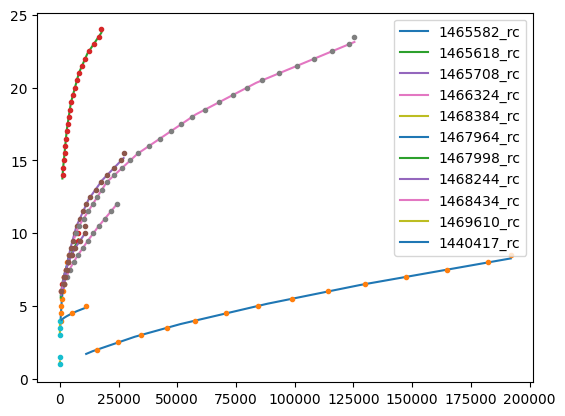

In [4]:
import matplotlib.pyplot as plt

xs=r.geom.cross_sections

new_flows,new_depths,new_wses=[],[],[]

for i,row in fcl.iterrows():

    r.plan=r.plans[row["feature_id"]+"_rc"]

    #read in flow/wse
    rc=r.plan.read_rating_curves()
    wses,flows=rc.values()

    #get the river_reach_rs for the cross section representing the upstream end of this reach
    river_reach_rs=xs.loc[xs["rs"]==row["us_rs"],"river_reach_rs"]

    wse=wses.loc[river_reach_rs,:].iloc[0]
    flow=flows.loc[river_reach_rs,:].iloc[0]

    #convert wse to depth
    thalweg=xs.loc[xs["rs"]==row["us_rs"],"thalweg"].iloc[0]
    depth=[e-thalweg for e in wse]

    new_flow,new_depth=create_flow_depth_array(flow,depth)
    new_flows.append(new_flow)

    #plot rating curve
    plt.plot(flow,depth,label=r.plan.title)
    plt.plot(new_flow,new_depth,".")
    
    #get the river_reach_rs for the cross section representing the downstream end of this reach
    river_reach_rs=xs.loc[xs["rs"]==row["ds_rs"],"river_reach_rs"]

    wse=wses.loc[river_reach_rs,:].iloc[0]
    flow=flows.loc[river_reach_rs,:].iloc[0]

    #convert wse to depth
    thalweg=xs.loc[xs["rs"]==row["ds_rs"],"thalweg"].iloc[0]
    depth=[e-thalweg for e in wse]

    new_flow,new_depth=create_flow_depth_array(flow,depth)
    
    new_depths.append(new_depth)
    new_wses.append([i+thalweg for i in new_depth])
    

plt.legend()
plt.show()
fcl["flows"]=new_flows
fcl["ds_depths"]=new_depths
fcl["ds_wses"]=new_wses

create RAS Terrain

In [5]:
src_dem="https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/13/TIFF/USGS_Seamless_DEM_13.vrt"

#create terrain
tif=r.clip_dem(src_dem)
r.create_terrain([tif])

['C:\\Program Files (x86)\\HEC\\HEC-RAS\\6.3.1\\RasProcess.exe', 'CreateTerrain', 'units=Feet', 'stitch=true', 'prj=C:\\Users\\mdeshotel\\Downloads\\test_stac2\\projection.prj', 'out=C:\\Users\\mdeshotel\\Downloads\\test_stac2\\Terrain\\Terrain.hdf', 'C:\\Users\\mdeshotel\\Downloads\\test_stac2\\Terrain\\Terrain.tif']


run the model 

In [ ]:
import os
from ras import RasMap


for i,row in fcl.iterrows():
    
    id=row["feature_id"]

    #write the new flow file
    r.write_new_flow_production_runs(id,row,.001)

    #write the new plan file
    r.write_new_plan(r.geom, r.flows[id], id, id)

    #update the content of the RAS project file
    r.update_content()
    r.set_current_plan(r.plans[str(id)])

    #write the update RAS project file content back to disk
    r.write()

    #manage rasmapper
    map_file=os.path.join(r.ras_folder,f"{r.ras_project_basename}.rasmap")
    profiles=r.plan.flow.profile_names
    plan_name=r.plan.title
    plan_hdf=os.path.basename(r.plan.text_file)+".hdf"

    if os.path.exists(map_file):
        os.remove(map_file)

    if os.path.exists(map_file+".backup"):
        os.remove(map_file+".backup")

    rm=RasMap(map_file,r.version)

    rm.update_projection(r.projection_file)

    rm.add_terrain()
    rm.add_plan_layer(plan_name,plan_hdf,profiles)
    rm.add_result_layers(plan_name,profiles)
    rm.write()

    #run the RAS plan
    r.RunSIM(close_ras=True, show_ras=True)


post-process/clip the resulting depth grids

In [ ]:
import os
import rasterio
import geopandas as gpd
from nwm_reaches import clip_depth_grid
import warnings

xs=r.geom.cross_sections

#contruct the dest directory for the clipped depth grid
dest_directory=os.path.join(r.ras_folder,"output")

#iterate thorugh the flow change locations
for i,nwm_reach_data in fcl.iterrows():

    id=row["feature_id"]
    
    #get cross section asociated with this nwm reach
    truncated_xs=xs[(xs["river"]==nwm_reach_data["river"]) & (xs["reach"]==nwm_reach_data["reach"]) & (xs["rs"]<=nwm_reach_data["us_rs"]) & (xs["rs"]>=nwm_reach_data["ds_rs"])]

    #create concave hull for this nwm reach/cross sections
    xs_hull=r.geom.xs_concave_hull(truncated_xs)
    
    #iterate through the profile names for this plan
    for profile_name in r.plans[id].flow.profile_names:

        #construct the default path to the depth grid for this plan/profile
        depth_file=os.path.join(r.ras_folder,str(id),f"Depth ({profile_name}).vrt")

        #if the depth grid path does not exists print a warning then continue to the next profile 
        if not os.path.exists(depth_file):

            warnings.warn(f"depth raster does not exists: {depth_file}")
            continue

        #clip the depth grid naming it with with river_reach_ds_rs_us_rs_flow_depth
        out_file=clip_depth_grid(depth_file,xs_hull,nwm_reach_data["river"],nwm_reach_data["reach"],nwm_reach_data["us_rs"],nwm_reach_data["ds_rs"],profile_name,dest_directory)
        